## Multi-task problem: colored MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset


import matplotlib.pyplot as plt

%matplotlib inline

### Colored [MNIST Dataset](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist)
* Handwritten digits with 10 classes
* Size of each image: 28x28 pixels 
* 50 000 data examples in training set, 10 000 examples in validation set, 10 000 in test set
* We colorize each image with a random color within 7 (red, green, blue, magenta, yellow, cyan, white)
* Each image has two labels: the number it represents (10 classes) and the color of the number (7 classes)

In [2]:
# Given a loaded MNIST dataset, create a colozied version of it
def colorize_dataset(dataset):
    # array of colors
    COLORS = torch.tensor([
        [1.0, 0.0, 0.0], # 0 RED
        [0.0, 1.0, 0.0], # 1 GREEN
        [0.0, 0.0, 1.0], # 2 BLUE
        [1.0, 1.0, 0.0], # 3 YELLOW
        [1.0, 0.0, 1.0], # 4 MAGENTA
        [0.0, 1.0, 1.0], # 5 CYAN
        [1.0, 1.0, 1.0], # 6 WHITE
    ])
    N = len(dataset)
    images = dataset.data.view(N, 1, 28, 28)
    labels = dataset.targets.view(N, 1)
    color_labels = torch.randint(0, 6, (N,))
    colorized_images = images * COLORS[color_labels, :].view(N,3,1,1)
    full_labels = torch.cat((labels, color_labels.view(N, 1)), dim=1)
    return TensorDataset(colorized_images, full_labels)
    

In [3]:
# Loading MNIST dataset from torchvision.dataset
dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

dataset = colorize_dataset(dataset)

In [4]:
print("The shape of the dataset is :", dataset.tensors[0].size())

The shape of the dataset is : torch.Size([60000, 3, 28, 28])


In [5]:
# split the dataset into training and validation sets
train_set, val_set = random_split(dataset, [50000, 10000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'image label: tensor([9, 5])')

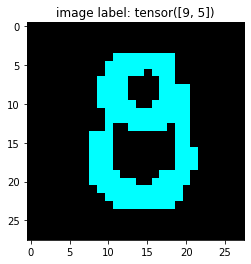

In [6]:
sample_index = 80

plt.imshow(dataset[sample_index][0].permute(1, 2, 0), interpolation='nearest')
plt.title("image label: {}".format(dataset[sample_index][1]))

### Training the neural network

In [7]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # The input size is 28*28. For a standard classification task, the output size should be the same as the number of classes
        self.l_number = nn.Linear(28*28*3, 10)
        # However here we deal with 2 tasks: the network outputs 2 labels, so there are two "last" layers in parallel
        self.l_color = nn.Linear(28*28*3, 7)
        
    def forward(self, inputs):
        h = inputs.view(-1, 28*28*3)
        # Use softmax as the activation function for the last layer(s)
        output_number = F.softmax(self.l_number(h), dim=1)
        output_color = F.softmax(self.l_color(h), dim=1)
        
        return (output_number, output_color)

In [34]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [9]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            (y_number, y_color) = model(images)
            
            # One-hot encoding or labels so as to calculate MSE error:
            number_onehot = F.one_hot(labels[:,0], 10).float()
            color_onehot = F.one_hot(labels[:,1], 7).float()
            
            loss = criterion(y_number, number_onehot) + criterion(y_color, color_onehot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [10]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss: 0.3584
Epoch [2/10], Loss: 0.2856
Epoch [3/10], Loss: 0.2755
Epoch [4/10], Loss: 0.2716
Epoch [5/10], Loss: 0.2713
Epoch [6/10], Loss: 0.2750
Epoch [7/10], Loss: 0.2715
Epoch [8/10], Loss: 0.2705
Epoch [9/10], Loss: 0.2712
Epoch [10/10], Loss: 0.2700


Text(0.5, 1.0, 'Visualization of convergence')

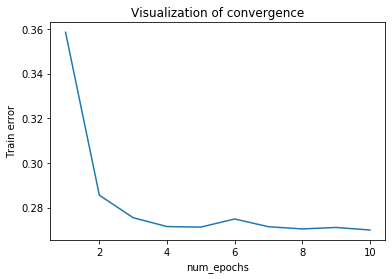

In [11]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the model on the validation set

In [36]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model, model_type='linear'):

    with torch.no_grad():
        number_correct = 0
        color_correct = 0
        both_correct = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images.view(-1, 28*28) if model_type == "linear" else images
            (y_number, y_color) = model(images)
            _, number_predicted = torch.max(y_number.data, 1) 
            number_correct += (number_predicted == labels[:, 0]).sum()
            _, color_predicted = torch.max(y_color.data, 1) 
            color_correct += (color_predicted == labels[:, 1]).sum()
            both_correct += ((color_predicted == labels[:, 1]) and (number_predicted == labels[:, 0])).sum()
    acc_color = 100*color_correct.item()/ len(dataset)
    acc_number = 100*number_correct.item()/ len(dataset)
    acc_both = 100*both_correct.item()/ len(dataset)
    print('Accuracy of the model for numbers : {:.2f} %'.format(acc_number))
    print('Accuracy of the model for colors : {:.2f} %'.format(acc_color))
    print('Accuracy of the model for both : {:.2f} %'.format(acc_both))
    return acc_number, acc_color, acc_both

In [37]:
accuracy(val_set, model)

Accuracy of the model for numbers : 13.50 %
Accuracy of the model for colors : 18.59 %
Accuracy of the model for both : 2.27 %


(13.5, 18.59, 2.27)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Prediction: number=8, color=0')

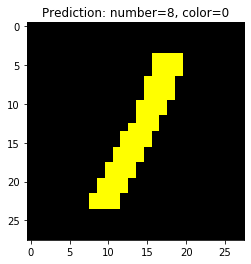

In [14]:
val_index = 66

(image, label) = val_set[val_index]
(y_number, y_color) = model(image)
_, number_prediction = torch.max(y_number.data, 1)
_, color_prediction = torch.max(y_color.data, 1)

plt.imshow(image.permute(1, 2, 0), interpolation='nearest')
plt.title("Prediction: number=%d, color=%d" % (number_prediction, color_prediction))

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.
* __Your network generates two different outputs, how much weight-sharing (i.e. how many common layers) between these two paths is appropriate?__

In [28]:
def conv_block(in_channels, out_channels, kernel_size, activation, *args, **kwargs):
    block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, *args, **kwargs), activation)
    return block

def linear_block(in_features, out_features, activation, *args, **kwargs):
    block = nn.Sequential(nn.Linear(in_features, out_features), activation)
    return block

class ConvModel(nn.Module):

    def __init__(self, activation:str, n_common_filters:list, n_number_filters:list, n_color_filters:list, n_common_neurons:list, n_number_neurons:list, n_color_neurons:list, in_channels=3, in_dim=28*28, out_dim=(10, 7), logits=False):
        super(ConvModel, self).__init__()

        activations = nn.ModuleDict([["relu", nn.ReLU()], ["lrelu", nn.LeakyReLU()], ["sigmoid", nn.Sigmoid()], ["tanh", nn.Tanh()]])
        self.logits = logits

        # Common encoder
        self.conv_common_space_dim = [in_channels, *n_common_filters]
        self.conv_common_blocks = [conv_block(in_channels, out_channels, kernel_size=3, activation=activations[activation], padding=1)
        for in_channels, out_channels in zip(self.conv_common_space_dim, self.conv_common_space_dim[1:])]
        self.common_encoder = nn.Sequential(*self.conv_common_blocks)

        # Color conv branch
        in_color_conv_channels = in_channels if not n_common_filters else n_common_filters[-1]
        self.conv_color_space_dim = [in_color_conv_channels, *n_color_filters]
        self.conv_color_blocks = [conv_block(in_channels, out_channels, kernel_size=3, activation=activations[activation], padding=1) for in_channels, out_channels in zip(self.conv_color_space_dim, self.conv_color_space_dim[1:])]
        self.color_encoder = nn.Sequential(*self.conv_color_blocks)

        # number conv branch
        in_number_conv_channels = in_channels if not n_common_filters else n_common_filters[-1]
        self.conv_number_space_dim = [in_number_conv_channels, *n_number_filters]
        self.conv_number_blocks = [conv_block(in_channels, out_channels, kernel_size=3, activation=activations[activation], padding=1) for in_channels, out_channels in zip(self.conv_number_space_dim, self.conv_number_space_dim[1:])]
        self.number_encoder = nn.Sequential(*self.conv_number_blocks)

        # Common fc
        in_fc_features = self.conv_common_space_dim[-1]*in_dim if not self.conv_color_space_dim else self.conv_color_space_dim[-1]*in_dim
        self.linear_common_space_dim = [in_fc_features, *n_common_neurons]
        self.linear_common_blocks = [linear_block(in_features, out_features, activations[activation]) for in_features, out_features in zip(self.linear_common_space_dim, self.linear_common_space_dim[1:])]
        self.common_fully_connected = nn.Sequential(*self.linear_common_blocks)
        self.final_color_layer = nn.Linear(self.linear_common_space_dim[-1], out_dim[0])
        self.final_number_layer = nn.Linear(self.linear_common_space_dim[-1], out_dim[1])

        # Color fc
        in_fc_color_features = self.conv_common_space_dim[-1]*in_dim if not n_common_neurons else n_common_neurons[-1]
        self.linear_color_space_dim = [in_fc_color_features, *n_color_neurons]
        self.linear_color_blocks = [linear_block(in_features, out_features, activations[activation]) for in_features, out_features in zip(self.linear_color_space_dim, self.linear_color_space_dim[1:])]
        self.color_fully_connected = nn.Sequential(*self.linear_color_blocks, nn.Linear(self.linear_color_space_dim[-1], out_dim[1]))

        # Number fc
        in_fc_number_features = self.conv_common_space_dim[-1]*in_dim if not n_common_neurons else n_common_neurons[-1]
        self.linear_number_space_dim = [in_fc_number_features, *n_number_neurons] 
        self.linear_number_blocks = [linear_block(in_features, out_features, activations[activation]) for in_features, out_features in zip(self.linear_number_space_dim, self.linear_number_space_dim[1:])]
        self.number_fully_connected = nn.Sequential(*self.linear_number_blocks, nn.Linear(self.linear_number_space_dim[-1], out_dim[0]))


        
    def forward(self, inputs):
        #outputs = F.softmax(self.encoder(inputs), dim=1)# Use softmax as the activation function for the last layer
        common_encoding = self.common_encoder(inputs)

        color_encoding = self.color_encoder(common_encoding) if self.conv_common_blocks else common_encoding
        number_encoding = self.number_encoder(common_encoding) if self.conv_common_blocks else common_encoding

        color_encoding = color_encoding.view(color_encoding.size(0), -1) # Flatten
        number_encoding = number_encoding.view(number_encoding.size(0), -1) # Flatten

        color_encoding = self.common_fully_connected(color_encoding)
        number_encoding = self.common_fully_connected(number_encoding)

        color_encoding = self.color_fully_connected(color_encoding) if self.linear_color_blocks else self.final_color_layer(color_encoding)
        number_encoding = self.number_fully_connected(number_encoding) if self.linear_number_blocks else self.final_number_layer(number_encoding)
    
        if not self.logits: output_numbers, output_colors = F.softmax(number_encoding, dim=1), F.softmax(color_encoding, dim=1)
        else: output_numbers, output_colors = number_encoding, color_encoding

        return output_numbers, output_colors

In [39]:
num_epochs = 3
batch_size = 10

model = ConvModel("relu", n_common_filters=[16, 16], n_color_filters=[], n_number_filters=[], n_common_neurons=[], n_color_neurons=[10], n_number_neurons=[10])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

acc_num, acc_col, acc = accuracy(val_set, model, model_type="conv")

Epoch [1/3], Loss: 0.0551
Epoch [2/3], Loss: 0.0738
Epoch [3/3], Loss: 0.0652
Accuracy of the model for numbers : 77.28 %
Accuracy of the model for colors : 82.91 %
Accuracy of the model for both : 64.02 %


### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [ ]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.MNIST(root='data/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)
test_set = colorize_dataset(test_set)

In [ ]:
accuracy(test_set, model)